In [1]:
import numpy as np
import cupy as cp

from holotomocupy.utils import *
from holotomocupy.holo import G
from holotomocupy.shift import S
from holotomocupy.tomo import R
from holotomocupy.chunking import gpu_batch
import sys
from holotomocupy.magnification import M
%matplotlib inline

np.random.seed(1) # fix randomness

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension

ntheta = 90  # number of angles (rotations)
noise = False
z1p = 12e-3

# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = sys.argv[2]=='True'
# z1p = float(sys.argv[3])  # positions of the code and the probe for reconstruction

center = n/2 # rotation axis
theta = cp.linspace(0, np.pi, ntheta,endpoint=False).astype('float32')  # projection angles

npos = 1  # number of code positions
detector_pixelsize = 3e-6*0.5
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0# np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16*0
# sample size after demagnification
ne = n+2*pad

show = True

flg = f'{n}_{ntheta}_{npos}_{noise}_{z1p}'

### Form the refractive index u = delta+i beta for a sample

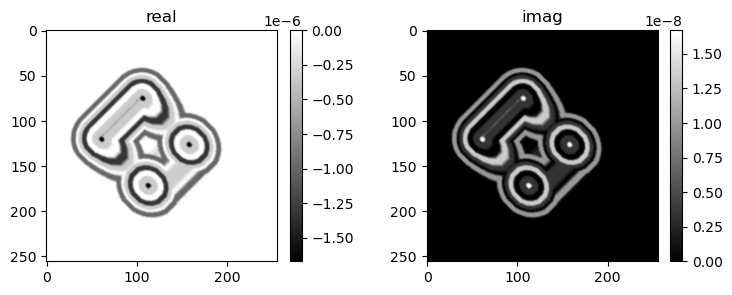

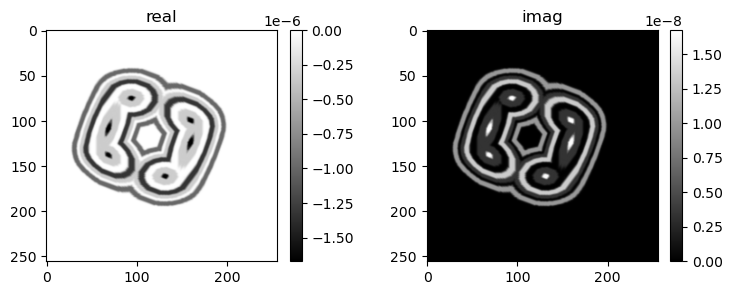

In [3]:
from scipy import ndimage

# cube_all = np.zeros([n, n, n], dtype='float32')
# rr = (np.ones(8)*n*0.25).astype(np.int32)
# amps = [3, -3, 1, 3, -4, 1, 4]  # , -2, -4, 5 ]
# dil = np.array([33, 28, 25, 21, 16, 10, 3])/256*n  # , 6, 3,1]
# for kk in range(len(amps)):
#     cube = np.zeros([n, n, n], dtype='bool')
#     r = rr[kk]
#     p1 = n//2-r//2
#     p2 = n//2+r//2
#     for k in range(3):
#         cube = cube.swapaxes(0, k)
#         cube[p1:p2, p1, p1] = True
#         cube[p1:p2, p1, p2] = True
#         cube[p1:p2, p2, p1] = True
#         cube[p1:p2, p2, p2] = True
#         # cube[p1:p2,p2,p2] = True

#     [x, y, z] = np.meshgrid(np.arange(-n//2, n//2),
#                             np.arange(-n//2, n//2), np.arange(-n//2, n//2))
#     circ = (x**2+y**2+z**2) < dil[kk]**2
#     # circ = (x**2<dil[kk]**2)*(y**2<dil[kk]**2)*(z**2<dil[kk]**2)

#     fcirc = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(circ)))
#     fcube = np.fft.fftshift(np.fft.fftn(
#         np.fft.fftshift(cube.astype('float32'))))
#     cube = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fcube*fcirc))).real
#     cube = cube > 1
#     cube_all += amps[kk]*cube

# # cube_all = ndimage.rotate(cube_all,52,axes=(1,2),reshape=False,order=1)
# cube_all = ndimage.rotate(cube_all, 28, axes=(0, 1), reshape=False, order=3)
# cube_all = ndimage.rotate(cube_all, 45, axes=(0, 2), reshape=False, order=3)
# cube_all[cube_all < 0] = 0


# u0 = cube_all  # (-1*cube_all*1e-6+1j*cube_all*1e-8)/3

# u0 = np.roll(u0, -15*n//256, axis=2)
# u0 = np.roll(u0, -10*n//256, axis=1)
# v = np.arange(-n//2, n//2)/n
# [vx, vy, vz] = np.meshgrid(v, v, v)
# v = np.exp(-10*(vx**2+vy**2+vz**2))
# fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u0)))
# u0 = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real
# u0[u0 < 0] = 0
# u0 = u0*(-1*1e-6+1j*1e-8)/3
# u = u0.astype('complex64')  

# !mkdir -p data
# np.save('data/u', u0)

# if exist then load and comment the above
u = np.load('data/u.npy').astype('complex64')

mshow_complex(u[:, n//2],show)
mshow_complex(u[n//2],show)

### Compute tomographic projection data $\mathcal{R}u$:

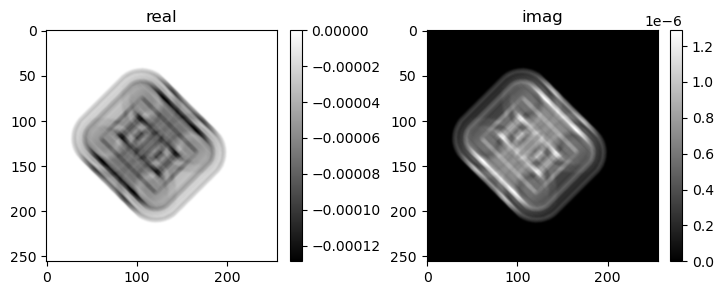

In [4]:
Ru = R(u, theta, center*ne/n)
Ru = Ru.swapaxes(0, 1)

mshow_complex(Ru[0],show)

### Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

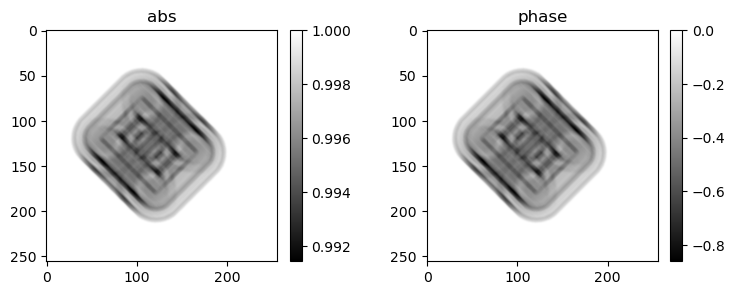

In [5]:
psi = np.exp(2*np.pi*1j/wavelength*voxelsize*Ru)
mshow_polar(psi[0],show)

## Use prb==1 for this test

In [6]:
prb = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')

### Generate a coded aperture, make it twice bigger than the sample to allow motion

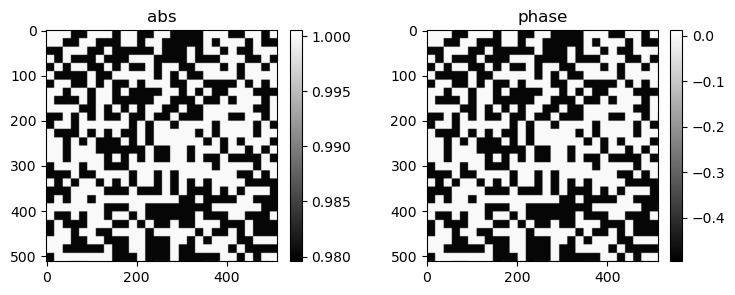

In [7]:
import random
import xraylib
import scipy.ndimage as ndimage

# thickness of the coded aperture
code_thickness = 1e-6 #in m
# feature size
ill_feature_size = 1e-6 #in m

random.seed(10)
nill = 2*ne
ill_global = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill_global.shape[0]):
    ill0 = np.zeros([nill*nill],dtype='bool')
    ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
    ill0[ill_ids] = 1
    ill_global[k] = ill0.reshape(nill,nill)

# form codes for simulations
nill = int(ne*voxelsize/magnifications2[0]//(ill_feature_size*2))*2
ill = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
    
ill = ndimage.zoom(ill,[1,2*ne/nill,2*ne/nill],order=0,grid_mode=True,mode='grid-wrap')

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = code_thickness/voxelsize # thickness in pixels

v = np.arange(-2*ne//2,2*ne//2)/2/ne
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-5*(vx**2+vy**2))
fill = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(ill)))
ill = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fill*v)))
ill = ill.astype('complex64')


# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
code = np.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')

# code=code*0+1
mshow_polar(code[0],show)

### Shifts of the code

In [8]:
# shifts of codes
shifts_code = np.round((np.random.random([ntheta, npos, 2]).astype('float32')-0.5)*ne/4)



### Compute holographic projections for all angles and all distances
#### $d=\left|\mathcal{G}_{z}(\mathcal{G}_{z'}(q\mathcal{S}_{s_{j}}c)\psi)\right|_2^2$, and reference data $d^r=\left|\mathcal{G}_{z+z'}(q(\mathcal{S}_{s_{j}'}c))\right|$

In [9]:
@gpu_batch
def _fwd_holo(psi, shifts_code, code, prb):
    prb = cp.array(prb)
    code = cp.array(code)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        # ill shift for each acquisition
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        # code shift for each acquisition
        coder = cp.tile(code, [psi.shape[0], 1, 1])
        coder = S(coder, shifts_code[:, i])
        # crop the code
        coder = coder[:, ne-n//2-pad:ne+n//2+pad, ne-n//2-pad:ne+n//2+pad]

        # multiply the code and ill
        prbr *= coder
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])

        psir = psi.copy()

        # multiply the ill and object
        psir *= prbr        
        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])
        # psir = cp.fft.fftshift(cp.fft.fft2(cp.fft.fftshift(psir)))
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data


def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, code, prb)


# Apply the forward transform
fpsi = fwd_holo(psi, prb)

### Take squared absolute value to simulate data on the detector and a reference image

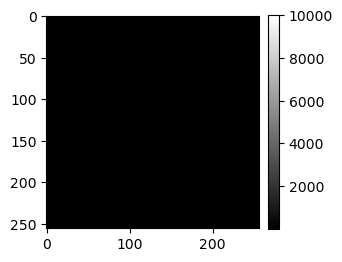

In [10]:
data = np.abs(fpsi)**2
# show a data example
mshow(data[0,0],show,vmax=10000)

In [11]:
if noise:
    datan = np.random.poisson(np.int32(data*550)).astype('float32')/550
    mshow(datan[0,0],show)
    mshow(data[0,0]-datan[0,0],show)
    data = datan

### Save data and the code

In [12]:
for k in range(npos):
    write_tiff(data[:,k],f'/data/vnikitin/coded_apertures/data/data_{k}_{flg}')
np.save(f'/data/vnikitin/coded_apertures/data/code_{flg}',code)
np.save(f'/data/vnikitin/coded_apertures/data/shifts_code_{flg}', shifts_code)

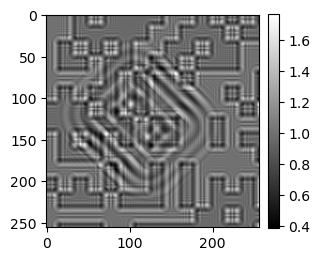

In [13]:
# mshow(data[ntheta//2,0,:,::-1],show)
mshow(data[0,0],show)

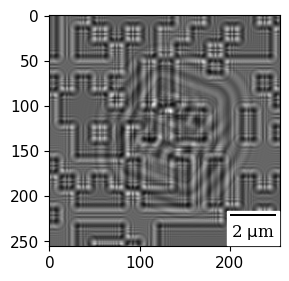

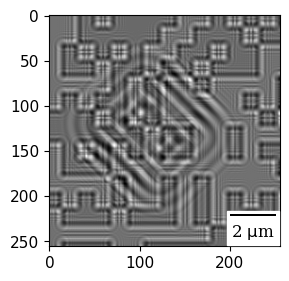

In [16]:
from matplotlib_scalebar.scalebar import ScaleBar
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(data[ntheta//2,0],cmap='gray')
scalebar = ScaleBar(voxelsize, "m", length_fraction=0.25, font_properties={
        "family": "serif",
        "size": "large",
    },  # For more information, see the cell below
    location="lower right")
ax.add_artist(scalebar)
ax.tick_params(axis='both', which='major', labelsize=11)
# plt.show()
plt.savefig('fig/coded90deg0dist.png',bbox_inches='tight',dpi=300)

from matplotlib_scalebar.scalebar import ScaleBar
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(data[0,0],cmap='gray')
scalebar = ScaleBar(voxelsize, "m", length_fraction=0.25, font_properties={
        "family": "serif",
        "size": "large",
    },  # For more information, see the cell below
    location="lower right")
ax.add_artist(scalebar)
# ax.xticks(fontsize=14)
# ax.yticks(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=11)
# fig.colorbar(im, ax=ax, orientation='vertical')

# plt.show()
plt.savefig('fig/coded0deg0dist.png',bbox_inches='tight',dpi=300)

In [ ]:
#for figure 1
# from matplotlib_scalebar.scalebar import ScaleBar
# fig, ax = plt.subplots(figsize=(3,3))
# ax.imshow(data[ntheta//2,0],cmap='gray')
# scalebar = ScaleBar(voxelsize, "m", length_fraction=0.25, font_properties={
#         "family": "serif",
#         "size": "large",
#     },  # For more information, see the cell below
#     location="lower right")
# ax.add_artist(scalebar)
# ax.tick_params(axis='both', which='major', labelsize=11)
# # plt.show()
# plt.savefig('fig/coded90deg.png',bbox_inches='tight',dpi=300)

# from matplotlib_scalebar.scalebar import ScaleBar
# fig, ax = plt.subplots(figsize=(3,3))
# im = ax.imshow(data[0,0],cmap='gray')
# scalebar = ScaleBar(voxelsize, "m", length_fraction=0.25, font_properties={
#         "family": "serif",
#         "size": "large",
#     },  # For more information, see the cell below
#     location="lower right")
# ax.add_artist(scalebar)
# # ax.xticks(fontsize=14)
# # ax.yticks(fontsize=14)
# ax.tick_params(axis='both', which='major', labelsize=11)
# # fig.colorbar(im, ax=ax, orientation='vertical')

# # plt.show()
# plt.savefig('fig/coded0deg.png',bbox_inches='tight',dpi=300)